# Step 0: Initialize Variables

In [1]:
sampleRate = 44100
chunkSize = 1024
bandPassLowCutoff = 40
bandPassHighCutoff = 120
bandPassGain = 1.0

print(f"sampleRate {sampleRate}")
print(f"chunkSize {chunkSize}")
print(f"bandPassLowCutoff {bandPassLowCutoff}")
print(f"bandPassHighCutoff {bandPassHighCutoff}")
print(f"bandPassGain {bandPassGain}")

sampleRate 44100
chunkSize 1024
bandPassLowCutoff 40
bandPassHighCutoff 120
bandPassGain 1.0


# Step 1: Load binary file

Script Dir: E:\Desktop\Projects\bpm-finder\tools\dsp\time_domain_onset_detection
Repository Root: E:\Desktop\Projects\bpm-finder
loaded 1317888 samples of audio data


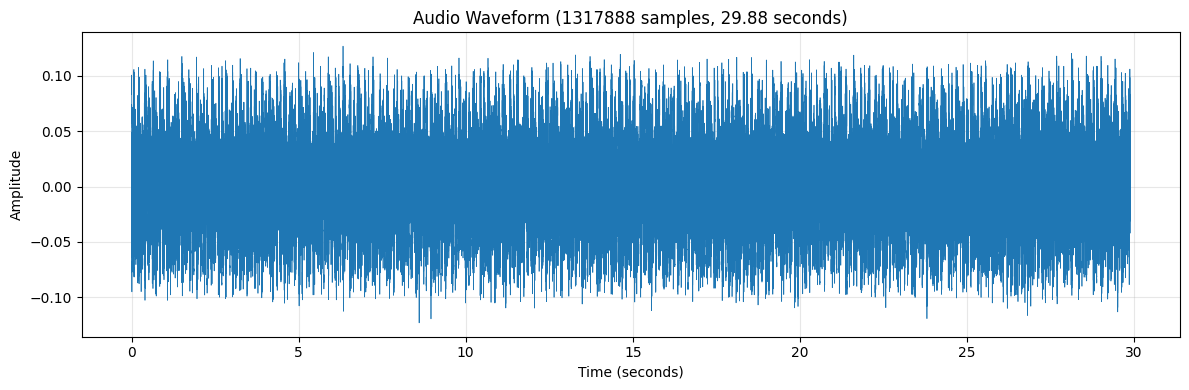

Waveform statistics:
  Min: -0.1232
  Max: 0.1268
  Mean: 0.0001
  Std: 0.0389


In [2]:
import subprocess
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Determine the executable path based on the platform
# In Jupyter notebooks, use os.getcwd() instead of __file__
script_dir = os.getcwd()
print(f"Script Dir: {script_dir}")
repository_root = os.path.dirname(os.path.dirname(os.path.dirname(script_dir)))
print(f"Repository Root: {repository_root}")

# Load binary data as float array
waveform_path = os.path.join(repository_root, 'cmake-build-debug', 'waveform.bin')
raw_data = np.fromfile(waveform_path, dtype=np.float32).tolist()
print(f'loaded {len(raw_data)} samples of audio data')

# Convert raw_data back to numpy array for plotting
waveform = np.array(raw_data)

# Create time axis (in seconds)
sample_rate = 44100  # Hz
duration = len(waveform) / sample_rate
time = np.linspace(0, duration, len(waveform))

# Create the plot
plt.figure(figsize=(12, 4))
plt.plot(time, waveform, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Audio Waveform ({len(waveform)} samples, {duration:.2f} seconds)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Waveform statistics:')
print(f'  Min: {np.min(waveform):.4f}')
print(f'  Max: {np.max(waveform):.4f}')
print(f'  Mean: {np.mean(waveform):.4f}')
print(f'  Std: {np.std(waveform):.4f}')

# Step 2: Initialize the result object (first pipeline stage)

In [3]:

if sys.platform == 'win32':
    executable = os.path.join(repository_root, 'cmake-build-debug', 'tools', 'PipelineResultInitialization.exe')
else:
    executable = os.path.join(repository_root, 'cmake-build-debug', 'tools', 'PipelineResultInitialization')

print(f"Executable: {executable}")
print(f"sampleRate {sampleRate}")
print(f"chunkSize {chunkSize}")
print(f"bandPassLowCutoff {bandPassLowCutoff}")
print(f"bandPassHighCutoff {bandPassHighCutoff}")
print(f"bandPassGain {bandPassGain}")

proc = subprocess.Popen(
    [executable, str(sampleRate), str(chunkSize), str(bandPassLowCutoff), str(bandPassHighCutoff), str(bandPassGain)],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1,
    universal_newlines=True
)

# Wait for ready signal
while True:
    status = proc.stdout.readline()
    if not status:
        print("Error: Process ended before ready signal")
        proc.terminate()
        sys.exit(1)
    print(status.strip())
    if "[LOG] ready" in status:
        print("exe is ready!")
        break

# Split raw_data into chunks and process each
resultObjects = []
total_samples = len(raw_data)
num_chunks = total_samples // chunkSize  # Floor division

print(f"Processing {num_chunks} chunks of size {chunkSize}")

for i in range(num_chunks):
    print(f'processing {i}')
    start_idx = i * chunkSize
    end_idx = min(start_idx + chunkSize, total_samples)
    chunk = raw_data[start_idx:end_idx]

    # Send audio chunk
    audio_data = {"rawAudio": chunk}
    proc.stdin.write(json.dumps(audio_data) + '\n')
    proc.stdin.flush()

    # Read result
    output = proc.stdout.readline()
    if output:
        result = json.loads(output)
        if result:
            print(f'processed {i}')
            resultObjects.append(result)
        else:
            print(f'processing {i} failed')

while True:
    status = proc.stdout.readline()
    if not status:
        print("Error: Process ended before process returned data")
        proc.terminate()
        sys.exit(1)
    print(status.strip())
    if "[LOG] exit" in status:
        print("exe is done!")
        break

# Read result
result = json.loads(proc.stdout.readline())
resultObjects.append(result)

print(f"Processed chunk {len(resultObjects)} samples)")

# Stop
proc.stdin.write('exit\n')
proc.stdin.flush()


Executable: E:\Desktop\Projects\bpm-finder\cmake-build-debug\tools\PipelineResultInitialization.exe
sampleRate 44100
chunkSize 1024
bandPassLowCutoff 40
bandPassHighCutoff 120
bandPassGain 1.0
[LOG] Sample Rate: 44100 Chunk Size: 1024 Bandpass: 40 - 120 Gain: 1
[LOG] Creating PipelineResultInitializationStage
[2025-10-23 23:47:59.032] [default] [info] Logging system initialized
[2025-10-23 23:47:59.033] [PipelineResultInitializationStage] [info] PipelineResultInitializationStage initialized - Sample Rate: 44100s, Chunk Size: 1024, Bandpass: 40 - 120 Hz Gain: 1
[LOG] Creating StageTestObserver
[LOG] Creating StageTestObservable
[LOG] ready
exe is ready!
Processing 1287 chunks of size 1024
processing 0


JSONDecodeError: Expecting value: line 1 column 2 (char 1)

# Step 3: Plot the waveform

In [8]:

# Convert raw_data back to numpy array for plotting
# Concatenate all result objects' data
all_data = []
for result in resultObjects:
    all_data.extend(result['rawData'])

waveform = np.array(all_data)

# Create time axis (in seconds)
sample_rate = resultObjects[0]['sampleRate']  # Hz
duration = len(waveform) / sample_rate
time = np.linspace(0, duration, len(waveform))

# Create the plot
plt.figure(figsize=(12, 4))
plt.plot(time, waveform, linewidth=0.5)

# Add vertical dotted lines at chunk boundaries
for i in range(1, len(resultObjects)):
    chunk_boundary_sample = i * chunkSize
    chunk_boundary_time = chunk_boundary_sample / sample_rate
    plt.axvline(x=chunk_boundary_time, color='red', linestyle=':', linewidth=1, alpha=0.7,
                label='Chunk boundary' if i == 1 else '')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Audio Waveform ({len(waveform)} samples, {duration:.2f} seconds, {len(resultObjects)} chunks)')
plt.grid(True, alpha=0.3)
if len(resultObjects) > 1:
    plt.legend()
plt.tight_layout()
plt.show()

print(f'Waveform statistics:')
print(f'  Total samples: {len(waveform)}')
print(f'  Number of chunks: {len(resultObjects)}')
print(f'  Chunk size: {chunkSize}')
print(f'  Min: {np.min(waveform):.4f}')
print(f'  Max: {np.max(waveform):.4f}')
print(f'  Mean: {np.mean(waveform):.4f}')
print(f'  Std: {np.std(waveform):.4f}')



SyntaxError: invalid syntax (2306328723.py, line 1)